In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_table('ratings.data',names=['user id', 'item id', 'rating', 'timestamp'])

In [3]:
user_index_list = df.loc[:,'user id'].unique()
item_index_list = df.loc[:,'item id'].unique()

def reindex(df):
    for i in tqdm(range(df.shape[0])):
        old_user_id = df.iloc[i].loc['user id']
        old_item_id = df.iloc[i].loc['item id']
        new_user_id = np.where(user_index_list == old_user_id)[0][0]+1
        new_item_id = np.where(item_index_list == old_item_id)[0][0]+1
        df.iloc[i].loc['user id'] = new_user_id
        df.iloc[i].loc['item id'] = new_item_id
    return df

In [4]:
df = reindex(df)

In [5]:
n = list(df.max().loc[['user id', 'item id']])
r = np.zeros(n)
train_set, test_set = train_test_split(df.to_numpy(), test_size=0.25)
for i in tqdm(train_set):
    r[i[0]-1,i[1]-1] = i[2]

In [6]:
def cos(x,y):
    if np.sqrt(np.dot(x,x)*np.dot(y,y)) == 0:
        return 0
    else:
        return np.dot(x,y)/np.sqrt(np.dot(x,x)*np.dot(y,y))
def pearson(x,y):
    if np.sum(x) == 0 or np.sum(y) == 0:
        return 0
    else:
        return np.corrcoef([x,y])[0,1]

def create_sim_mat(r_mat, base, similar):
    if base != 'user':
        r_mat = r_mat.T
    sim_mat = np.zeros([r_mat.shape[0]]*2)
    for i in tqdm(range(sim_mat.shape[0])):
        for j in range(sim_mat.shape[0]):
            if i < j:
                if similar == 'cos':
                    sim = cos(r_mat[i],r_mat[j])
                else:
                    sim = pearson(r_mat[i],r_mat[j])
                if np.isnan(sim):
                    sim_mat[i,j] = 0
                else:
                    sim_mat[i,j] = sim
    return sim_mat+sim_mat.T

In [7]:
def find_kmax(array,k):
    return array.argsort()[-k:]

def CF(test_set, r_mat, sim_mat, base, similar, k):
    if base != 'user':
        r_mat = r_mat.T
    y_hat = []

    for i in tqdm(test_set):
        if base == 'user':
            m_id = i[0]-1
            s_id = i[1]-1
        else:
            m_id = i[1]-1
            s_id = i[0]-1
        if np.count_nonzero(r_mat[m_id]):
            sim_index = find_kmax(sim_mat[m_id],k)
            if sim_mat[m_id][sim_index].sum()!=0:
                r = np.dot(sim_mat[m_id][sim_index],r_mat[sim_index][:,s_id])/sim_mat[m_id][sim_index].sum()
            else:
                r = 0
        else:
            r = 0
            
        y_hat.append(r)
    
    loss = mean_squared_error(test_set[:,2],y_hat)
    RMSE = np.sqrt(loss)
    print(f'{base}-base model / similar method: {similar} / k={k} => RMSE:{RMSE}')
    return RMSE

In [8]:
bases = ['user', 'item']
similar_methods = ['cos', 'pearson']
user_cos_sim_mat = create_sim_mat(r, bases[0], similar_methods[0])
user_pear_sim_mat = create_sim_mat(r, bases[0], similar_methods[1])
item_cos_sim_mat = create_sim_mat(r, bases[1], similar_methods[0])
item_pear_sim_mat = create_sim_mat(r, bases[1], similar_methods[1])

user_cos_sim_mat_loss = []
user_pear_sim_mat_loss = []
item_cos_sim_mat_loss = []
item_pear_sim_mat_loss = []
    

In [9]:
ks = [k for k in range(3,10)]+[k for k in range(10,60,10)]
for k in ks:
    user_cos_sim_mat_loss.append(CF(test_set, r, user_cos_sim_mat, bases[0], similar_methods[0], k))
    
for k in ks:
    user_pear_sim_mat_loss.append(CF(test_set, r, user_pear_sim_mat, bases[0], similar_methods[1], k))

for k in ks:
    item_cos_sim_mat_loss.append(CF(test_set, r, item_cos_sim_mat, bases[1], similar_methods[0], k))

for k in ks:
    item_pear_sim_mat_loss.append(CF(test_set, r, item_pear_sim_mat, bases[1], similar_methods[1], k))


user-base model / similar method: cos / k=3 => RMSE:2.6517570076270287



user-base model / similar method: cos / k=4 => RMSE:2.624084949751048



user-base model / similar method: cos / k=5 => RMSE:2.6008858409209914



user-base model / similar method: cos / k=6 => RMSE:2.5855165903416295



user-base model / similar method: cos / k=7 => RMSE:2.5793633534404794



user-base model / similar method: cos / k=8 => RMSE:2.574499671967206



user-base model / similar method: cos / k=9 => RMSE:2.5689275834657446



user-base model / similar method: cos / k=10 => RMSE:2.5645411907713243



user-base model / similar method: cos / k=20 => RMSE:2.5563937563694616



user-base model / similar method: cos / k=30 => RMSE:2.5676654100882446



user-base model / similar method: cos / k=40 => RMSE:2.5804583940202903



user-base model / similar method: cos / k=50 => RMSE:2.5955380157064196



user-base model / similar method: pearson / k=3 => RMSE:2.775654875704315



user-base model / similar method: pearson / k=4 => RMSE:2.733587965283488



user-base model / similar method: pearson / k=5 => RMSE:2.7160403036966203



user-base model / similar method: pearson / k=6 => RMSE:2.6974751703835405



user-base model / similar method: pearson / k=7 => RMSE:2.688490792624041



user-base model / similar method: pearson / k=8 => RMSE:2.681000369716987



user-base model / similar method: pearson / k=9 => RMSE:2.677062876121221



user-base model / similar method: pearson / k=10 => RMSE:2.675638791279528



user-base model / similar method: pearson / k=20 => RMSE:2.666381675840643



user-base model / similar method: pearson / k=30 => RMSE:2.6766269365555337



user-base model / similar method: pearson / k=40 => RMSE:2.684288914865079



user-base model / similar method: pearson / k=50 => RMSE:2.6937418104464097



item-base model / similar method: cos / k=3 => RMSE:2.5499662119682074



item-base model / similar method: cos / k=4 => RMSE:2.5026767643922856



item-base model / similar method: cos / k=5 => RMSE:2.481883780514972



item-base model / similar method: cos / k=6 => RMSE:2.4647931412105764



item-base model / similar method: cos / k=7 => RMSE:2.4555566019532966



item-base model / similar method: cos / k=8 => RMSE:2.4522233475312794



item-base model / similar method: cos / k=9 => RMSE:2.4487025897776102



item-base model / similar method: cos / k=10 => RMSE:2.448857745308995



item-base model / similar method: cos / k=20 => RMSE:2.4642616017394543



item-base model / similar method: cos / k=30 => RMSE:2.485145363393461



item-base model / similar method: cos / k=40 => RMSE:2.50800133890881



item-base model / similar method: cos / k=50 => RMSE:2.5305649302733744



item-base model / similar method: pearson / k=3 => RMSE:2.7774679184056743



item-base model / similar method: pearson / k=4 => RMSE:2.738302892215653



item-base model / similar method: pearson / k=5 => RMSE:2.7214066003284794



item-base model / similar method: pearson / k=6 => RMSE:2.7107673388883375



item-base model / similar method: pearson / k=7 => RMSE:2.7059525815974297



item-base model / similar method: pearson / k=8 => RMSE:2.7047040300997915



item-base model / similar method: pearson / k=9 => RMSE:2.704174087840193



item-base model / similar method: pearson / k=10 => RMSE:2.7004564745132913



item-base model / similar method: pearson / k=20 => RMSE:2.715245993274936



item-base model / similar method: pearson / k=30 => RMSE:2.7361667050073875



item-base model / similar method: pearson / k=40 => RMSE:2.755510684282842



item-base model / similar method: pearson / k=50 => RMSE:2.7726720492841452


No handles with labels found to put in legend.


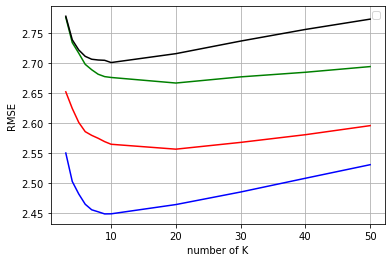

In [10]:
plt.figure()
plt.plot(ks,user_cos_sim_mat_loss,color='red')
plt.plot(ks,user_pear_sim_mat_loss, color='green')
plt.plot(ks,item_cos_sim_mat_loss, color='blue')
plt.plot(ks,item_pear_sim_mat_loss, color='black')
plt.xlabel('number of K')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()

In [11]:
class MF_bias():
    def __init__(self, r_true, k, alph, lmbda):
        self.r_true = r_true
        self.k = k
        self.alph = alph
        self.lmbda = lmbda
        self.xm = np.random.uniform(0,3,[n[0],k])
        self.ym = np.random.uniform(0,3,[k,n[1]])
        self.mu = r_true[r_true!=0].mean()
        self.bu = r_true.sum(1)/(r_true!=0).sum(1) - self.mu
        if ((r_true!=0).sum(0) != 0).all():
            self.bi = self.r_true.sum(0)/(self.r_true!=0).sum(0) - self.mu
        else:
            self.bi = np.zeros(n[1])
        self.r_hat = ((np.dot(self.xm,self.ym)+self.bi).T+self.bu).T
        
    def __call__(self, u_id, i_id, update=False):            
        
        if update:
            e = self.r_hat[u_id,i_id] - self.r_true[u_id,i_id]
            bias = np.array([self.mu,self.bu[u_id],self.bi[i_id]])
            grad_x = self.alph*(e*self.ym[:,i_id]+self.lmbda*self.xm[u_id])
            grad_y = self.alph*(e*self.xm[u_id]+self.lmbda*self.ym[:,i_id])
            grad_bias = self.alph*(e + self.lmbda * bias)
        
            self.xm[u_id] = self.xm[u_id] - grad_x
            self.ym[:,i_id] = self.ym[:,i_id] - grad_y
            bias = bias - grad_bias
            self.mu, self.bu[u_id], self.bi[i_id] = bias[0], bias[1], bias[2]
        
        self.r_hat[u_id] = np.dot(self.xm[u_id],self.ym)+self.bu[u_id]+self.bi+self.mu
        self.r_hat[:,i_id] = np.dot(self.xm,self.ym[:,i_id])+self.bu+self.bi[i_id]+self.mu
        
        return self.r_hat[u_id,i_id]

In [12]:
class MF_nobias():
    def __init__(self, r_true, k, alph, lmbda):
        self.r_true = r_true
        self.k = k
        self.alph = alph
        self.lmbda = lmbda
        self.xm = np.random.uniform(0,3,[n[0],k])
        self.ym = np.random.uniform(0,3,[k,n[1]])
        self.r_hat = np.dot(self.xm,self.ym)
        
    def __call__(self, u_id, i_id, update=False):
        
        if update:
            e = self.r_hat[u_id,i_id] - self.r_true[u_id,i_id]
            grad_x = self.alph*(e*self.ym[:,i_id]+self.lmbda*self.xm[u_id])
            grad_y = self.alph*(e*self.xm[u_id]+self.lmbda*self.ym[:,i_id])

            self.xm[u_id] = self.xm[u_id] - grad_x
            self.ym[:,i_id] = self.ym[:,i_id] - grad_y
            
        self.r_hat[u_id] = np.dot(self.xm[u_id],self.ym)
        self.r_hat[:,i_id] = np.dot(self.xm,self.ym[:,i_id])
        
        return self.r_hat[u_id,i_id]

In [13]:
train_losses = []
test_losses = []

model_b = MF_bias(r, 20, 0.01, 0.1)
model_nb = MF_nobias(r, 20, 0.01, 0.1)

for i in tqdm(range(100)):
    losses = []
    for row in train_set:
        u_id = row[0]-1
        i_id = row[1]-1
        y_true = row[2]
        y_hat_b = model_b(u_id, i_id, True)
        y_hat_nb = model_nb(u_id,i_id,True)
        e = np.array([y_hat_b,y_hat_nb])-y_true
        losses.append(e**2)
    
    losses = np.array(losses) 
    train_RMSE = np.sqrt(np.mean(losses,axis=0))
    train_losses.append(train_RMSE)

    u_id = test_set[:,0]-1
    i_id = test_set[:,1]-1
    y_true = test_set[:,2]
    e = np.array([model_b.r_hat[u_id,i_id],model_nb.r_hat[u_id,i_id]])-y_true

    test_RMSE = np.sqrt(np.mean(e**2,axis=1))
    test_losses.append(test_RMSE)
    #print(f'Model Bias Training RMSE: {train_RMSE[0]}  Testing RMSE: {test_RMSE[0]}\nModel no Bias Training RMSE: {train_RMSE[1]}  Testing RMSE: {test_RMSE[1]}')

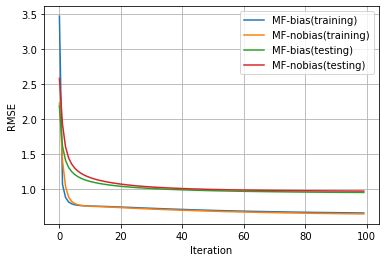

In [14]:
train_losses = np.array(train_losses).T
test_losses = np.array(test_losses).T
plt.figure()
plt.plot(train_losses[0], label='MF-bias(training)')
plt.plot(train_losses[1], label='MF-nobias(training)')
plt.plot(test_losses[0], label='MF-bias(testing)')
plt.plot(test_losses[1], label='MF-nobias(testing)')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()

In [16]:
train_k_losses = []
test_k_losses = []

k_dim = np.arange(5,101,5)
for k in tqdm(k_dim):
    model_b = MF_bias(r, k, 0.01, 0.1)
    model_nb = MF_nobias(r, k, 0.01, 0.1)

    for i in range(30):
        for row in train_set:
            u_id = row[0]-1
            i_id = row[1]-1
            y_hat_b = model_b(u_id, i_id, True)
            y_hat_nb = model_nb(u_id,i_id,True)
    losses=[]
    for row in train_set:
        u_id = row[0]-1
        i_id = row[1]-1
        y_true = row[2]
        y_hat_b = model_b(u_id, i_id, True)
        y_hat_nb = model_nb(u_id,i_id,True)
        e = np.array([y_hat_b,y_hat_nb])-y_true
        losses.append(e**2)
    losses = np.array(losses)
    train_RMSE = np.sqrt(np.mean(losses,axis=0))
    train_k_losses.append(train_RMSE)
    
    losses = []
    for row in test_set:
        u_id = row[0]-1
        i_id = row[1]-1
        y_true = row[2]
        y_hat_b = model_b(u_id,i_id)
        y_hat_nb = model_nb(u_id,i_id)
        e = np.array([y_hat_b,y_hat_nb])-y_true
        losses.append(e**2)

    losses = np.array(losses)
    test_RMSE = np.sqrt(np.mean(losses,axis=0))
    test_k_losses.append(test_RMSE)

<ipython-input-11-ad83d3582591>:22: RuntimeWarning: overflow encountered in multiply
  grad_x = self.alph*(e*self.ym[:,i_id]+self.lmbda*self.xm[u_id])
<ipython-input-11-ad83d3582591>:23: RuntimeWarning: overflow encountered in multiply
  grad_y = self.alph*(e*self.xm[u_id]+self.lmbda*self.ym[:,i_id])
<ipython-input-11-ad83d3582591>:28: RuntimeWarning: invalid value encountered in subtract
  bias = bias - grad_bias
<ipython-input-12-7fdd9b5475e8>:16: RuntimeWarning: overflow encountered in multiply
  grad_y = self.alph*(e*self.xm[u_id]+self.lmbda*self.ym[:,i_id])
<ipython-input-12-7fdd9b5475e8>:15: RuntimeWarning: overflow encountered in multiply
  grad_x = self.alph*(e*self.ym[:,i_id]+self.lmbda*self.xm[u_id])
<ipython-input-11-ad83d3582591>:32: RuntimeWarning: invalid value encountered in add
  self.r_hat[:,i_id] = np.dot(self.xm,self.ym[:,i_id])+self.bu+self.bi[i_id]+self.mu
<ipython-input-11-ad83d3582591>:31: RuntimeWarning: invalid value encountered in add
  self.r_hat[u_id] = np.d

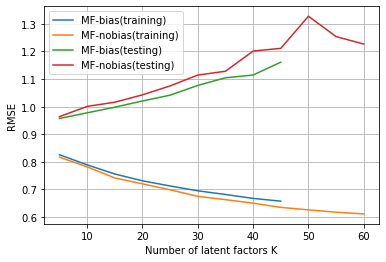

In [31]:
train_k_losses = np.array(train_k_losses).T
test_k_losses = np.array(test_k_losses).T
plt.figure()
plt.plot(k_dim , train_k_losses[0], label='MF-bias(training)')
plt.plot(k_dim, train_k_losses[1], label='MF-nobias(training)')
plt.plot(k_dim, test_k_losses[0], label='MF-bias(testing)')
plt.plot(k_dim, test_k_losses[1], label='MF-nobias(testing)')
plt.xlabel('Number of latent factors K')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()

In [26]:
default = []
tuned = []

default.append(user_cos_sim_mat_loss[6])
default.append(user_pear_sim_mat_loss[6])
default.append(item_cos_sim_mat_loss[6])
default.append(item_pear_sim_mat_loss[6])
default.append(test_losses[0][-1])
default.append(test_losses[1][-1])

tuned.append(min(user_cos_sim_mat_loss))
tuned.append(min(user_pear_sim_mat_loss))
tuned.append(min(item_cos_sim_mat_loss))
tuned.append(min(item_pear_sim_mat_loss))
tuned.append(min(test_k_losses[0]))
tuned.append(min(test_k_losses[1]))


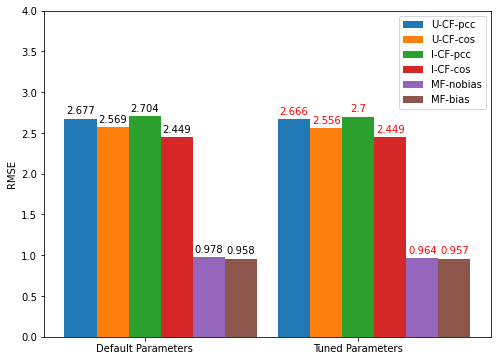

In [22]:
labels = ['Default Parameters', 'Tuned Parameters']
x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

xy = (- width*2, - width*1, - width*0, + width*1, + width*2, + width*3)

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x + xy[0], [default[1],tuned[1]], width, label='U-CF-pcc')
rects2 = ax.bar(x + xy[1], [default[0],tuned[0]], width, label='U-CF-cos')
rects3 = ax.bar(x + xy[2], [default[3],tuned[3]], width, label='I-CF-pcc')
rects4 = ax.bar(x + xy[3], [default[2],tuned[2]], width, label='I-CF-cos')
rects5 = ax.bar(x + xy[4], [default[5],tuned[5]], width, label='MF-nobias')
rects6 = ax.bar(x + xy[5], [default[4],tuned[4]], width, label='MF-bias')

ax.set_ylabel('RMSE')
ax.set_ylim((0, 4))
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    
    if rects[0].get_height() < rects[1].get_height():
        color = ['red', 'black']
    else:
        color = ['black', 'red']    
    
    for i, rect in enumerate(rects):
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 3)),
                    xy=(rect.get_x()+rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', color=color[i])

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)
autolabel(rects6)